<a href="https://colab.research.google.com/github/aditya02shah/LipReadingAI/blob/main/Lip_Reading_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [ ]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import gdown
from typing import List
import imageio
import numpy as np
from glob import glob

In [ ]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
cata

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##Importing Data

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 95.0MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

##Data Loading Functions

In [ ]:
def load_video(path):
  cap=cv2.VideoCapture(path)
  frames=[]
  for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame=cap.read()
    frame=tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:]) ##isolating mouth region
  cap.release()

  mean=tf.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames - mean),tf.float32) / std

In [ ]:
vocab=[x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path):
  with open(path,'r') as f:
    lines=f.readlines()
  tokens=[]
  for line in lines:
    line=line.split()
    if line[2]!='sil':
      tokens=[*tokens,' ',line[2]]
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [ ]:
def load_data(path): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content','data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path = '/content/data/s1/swaizn.mpg'
frames,alignments=load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4705769 ],
         [1.4705769 ],
         [1.5064447 ],
         ...,
         [0.39454502],
         [0.32280958],
         [0.32280958]],

        [[1.4705769 ],
         [1.3988415 ],
         [1.5423124 ],
         ...,
         [0.39454502],
         [0.32280958],
         [0.32280958]],

        [[1.3988415 ],
         [1.3988415 ],
         [1.3629737 ],
         ...,
         [0.39454502],
         [0.3586773 ],
         [0.3586773 ]],

        ...,

        [[1.0760319 ],
         [1.0760319 ],
         [1.0401641 ],
         ...,
         [0.14347091],
         [0.14347091],
         [0.14347091]],

        [[1.0760319 ],
         [1.0760319 ],
         [1.0401641 ],
         ...,
         [0.14347091],
         [0.10760319],
         [0.10760319]],

        [[1.0760319 ],
         [1.0760319 ],
         [1.0401641 ],
         ...,
         [0.10760319],
         [0.10760319],
         [0.07173546]]],


  

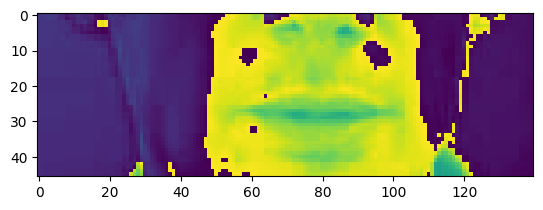

In [ ]:
plt.imshow(frames[0])

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white at i zero now'>

In [ ]:
def mappable_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

##Building Data Pipeline

In [ ]:
vid_path=sorted(glob(os.path.join('/content/data/s1',"*.mpg")))
ali_path=sorted(glob(os.path.join('/content/data/alignments/s1',"*.align")))

In [ ]:
data = tf.data.Dataset.list_files((os.path.join('/content/data/s1',"*.mpg")))
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [ ]:
len(train),len(test)

(450, 50)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.213404  ],
          [ 1.213404  ],
          [ 1.1754851 ],
          ...,
          [ 0.5308643 ],
          [ 0.606702  ],
          [ 0.37918878]],

         [[ 1.213404  ],
          [ 1.213404  ],
          [ 1.1754851 ],
          ...,
          [ 0.4929454 ],
          [ 0.606702  ],
          [ 0.34126988]],

         [[ 1.0996474 ],
          [ 1.0996474 ],
          [ 1.0996474 ],
          ...,
          [ 0.37918878],
          [ 0.8342153 ],
          [ 0.68253976]],

         ...,

         [[ 0.75837755],
          [ 0.75837755],
          [ 0.75837755],
          ...,
          [ 8.417991  ],
          [ 7.8492074 ],
          [ 8.304234  ]],

         [[ 0.7204586 ],
          [ 0.7204586 ],
          [ 0.7204586 ],
          ...,
          [ 9.024693  ],
          [ 7.318343  ],
          [ 8.038802  ]],

         [[ 0.7204586 ],
          [ 0.7204586 ],
          [ 0.7204586 ],
          ...,
          [ 9.631394  ],
          [ 7.2045865 ],
          

In [ ]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

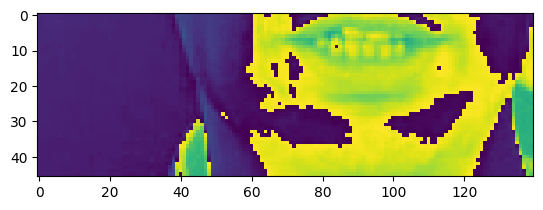

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at y seven again'>

##Designing the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
## 3-D Conv Layer works better with videos

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
yhat=model.predict(val[0]) #Prediction before training

1/1 [==============================] - 11s 11s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]) #result of prediction

<tf.Tensor: shape=(), dtype=string, numpy=b'tttttttttttt?ttttttttttttttttttttttt11111fffffffffffffffffffffffffffffffffc'>

In [ ]:
model.input_shape,model.output_shape

((None, 75, 46, 140, 1), (None, 75, 41))

##Training

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

##Making Predictions

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 88.7MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 265ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white with b zero please'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with t one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white with b zero please'>]

##Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bbaf5a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 838ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]